## Post-facto analysis of 2016-September annealing event

See http://occweb.cfa.harvard.edu/twiki/Aspect/AcaAnnealing#2016_ACA_CCD_Annealing_Activity
for planning details.

* Best-fit dark current scaling is a factor of 1.59 increase per 4 C increase using a linear fit.
* The annealing pathfinder found a value of 1.70.
* Adding a quadratic component gives a better fit and provides evidence for a turnover, but the fits are not all consistent.


### Solve for scale factor using annealing pathfinder data

In [1]:
from __future__ import division, print_function

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import logging
import os

from scipy.ndimage.filters import median_filter
import numpy as np
import matplotlib.pyplot as plt
from sherpa import ui
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from mica.archive.aca_dark.dark_cal import DARK_SCALE_4C
from astropy.table import Table

from mica.archive import aca_hdr3
from mica.archive import aca_l0

In [4]:
def dark_temp_scale(t_ccd, t_ccd_ref=-19.0, scale_4c=None, scale_quad=0.0):
    """Return the multiplicative scale factor to convert a CCD dark map
    or dark current value from temperature ``t_ccd`` to temperature
    ``t_ccd_ref``::

      dx = (t_ccd_ref - t_ccd) / 4.0
      scale = scale_4c ** dx * exp(scale_quad) ** (dx**2)
      scale = exp(log(scale_4c) * dx + scale_quad * dx**2)

    In other words, if you have a dark current value that corresponds to ``t_ccd``
    and need the value at a different temperature ``t_ccd_ref`` then use the
    the following.  Do not be misled by the misleading parameter names.

      >>> from mica.archive.aca_dark import dark_temp_scale
      >>> scale = dark_temp_scale(t_ccd, t_ccd_ref, scale_4c)
      >>> dark_curr_at_t_ccd_ref = scale * dark_curr_at_t_ccd

    The default value for ``scale_4c`` is 1.0 / 0.7.  It is written this way
    because the equation was previously expressed using 1 / scale_4c with a
    value of 0.7. This value is based on best global fit for dark current model
    in `plot_predicted_warmpix.py`.  This represents the multiplicative change
    in dark current for each 4 degC increase::

      >>> dark_temp_scale(t_ccd=-18, t_ccd_ref=-10, scale_4c=2.0)
      4.0

    :param t_ccd: actual temperature (degC)
    :param t_ccd_ref: reference temperature (degC, default=-19.0)
    :param scale_4c: increase in dark current per 4 degC increase (default=1.0 / 0.7)

    :returns: scale factor
    """
    if scale_4c is None:
        scale_4c = DARK_SCALE_4C
        
    dx = (t_ccd_ref - t_ccd) / 4.0

    return scale_4c**dx * exp(scale_quad)**(dx**2)


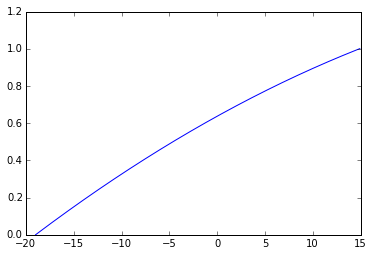

In [5]:
t_ccd = np.arange(-19, 15, .1)
scale = dark_temp_scale(-19.0, t_ccd, scale_quad=-0.01)
plot(t_ccd, log10(scale))

These routines were used during the pathfinder to fit a scale factor to the pixel e-/sec data.

In [6]:
T_CCD_REF = 0  # not -19 # Reference temperature for dark current values in degC          

def dark_scale_model(pars, t_ccd):
    """                                                                          
    dark_t_ref : dark current of a pixel at the reference temperature            
    scale : dark current model scale factor                                      
    returns : dark_t_ref scaled to the observed temperatures t_ccd               
    """
    scale, dark_t_ref, scale_quad = pars
    scaled_dark_t_ref = dark_t_ref * dark_temp_scale(T_CCD_REF, t_ccd, 1 / scale, scale_quad=scale_quad)
    return scaled_dark_t_ref

def fit_pix_values(t_ccd, esec, id=1, scale_quad=0.0, fit_scale_quad=False):
    logger = logging.getLogger("sherpa")
    logger.setLevel(logging.WARNING)
    data_id = id
    ui.set_method('simplex')
    ui.load_user_model(dark_scale_model, 'model')
    ui.add_user_pars('model', ['scale', 'dark_t_ref', 'scale_quad'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id,
                   np.array(t_ccd),
                   np.array(esec))
    d = ui.get_data(id)
    d.staterror = 30 * np.ones(len(t_ccd))
    model.scale = 0.70
    model.scale.min = 0.4
    model.scale.max = 1.0
    model.dark_t_ref = 500
    model.dark_t_ref.min = 50
    model.dark_t_ref.max = 5000
    model.scale_quad = scale_quad
    model.scale_quad.min = -0.05
    model.scale_quad.max = 0.05
    ui.freeze(model.scale)
    ui.freeze(model.scale_quad)
    # If more than 5 degrees in the temperature range,                           
    # thaw and fit for model.scale.  Else just use/return                        
    # the fit of dark_t_ref                                                      
    if np.max(t_ccd) - np.min(t_ccd) > 2:
        # Fit first for dark_t_ref                                               
        ui.fit(data_id)
        ui.thaw(model.scale)
        if fit_scale_quad:
            ui.thaw(model.scale_quad)
    ui.fit(data_id)
    return ui.get_fit_results(), ui.get_model(data_id)

Get the data for the interval from the monitor window slots.

In [7]:
start = '2016:257:10:45:00.000'
stop = '2016:258:00:30:00.000'
GAIN = 5.0
ccd_temp = aca_hdr3.MSID('ccd_temp', start, stop)
slot6 = aca_l0.get_slot_data(start, stop, 6)
slot7 = aca_l0.get_slot_data(start, stop, 7)

## Warming and cooling performance

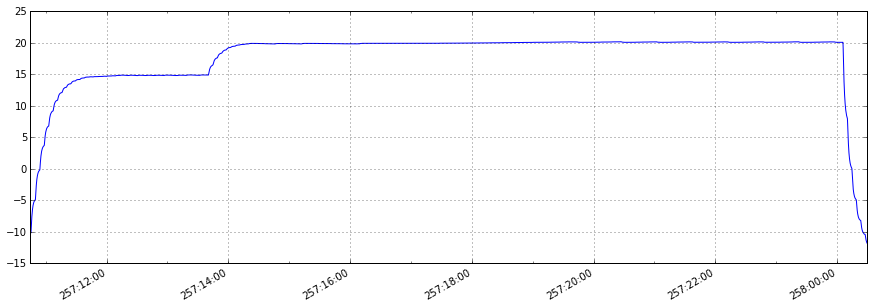

In [8]:
plt.figure(figsize=(15,5))
plot_cxctime(ccd_temp.times, ccd_temp.vals)
plt.grid()

In [9]:
def read_splat_dat():
    """
    Parse blocks like this:

        Format: 2  VCDU: 14881476 (116261,068)

    Header: 00 07 00 00 00 b3 69 e4  int_tim:0007  cal:0 chk:0 syn:0 cnt:00
    INT_TIME=   0.112 sec  CCD_Temp= -14.8  AChous_Temp= 25.6
    Raw 0: 04 0a db 40 3f 3d ff 03 42 11 cd 71 26 82 70 4c 0a 04 03 da c7 95 ff 4d 40 9c 0c
    Raw 1: 14 02 46 cc 02 20 04 03 40 c0 38 0f 03 80 d0 30 0c 03 80 f0 4c 15 05 01 00 3c 0e
    Raw 2: 24 20 43 1f e1 1f ee 05 c5 99 06 2e e3 19 60 9c 14 04 41 c1 25 58 65 43 d0 58 11
    Raw 3: 34 00 c6 00 0f a3 d4 06 44 ec 5b 02 bc 6a 70 dc 15 04 c2 83 6d cb ca da c0 98 13
    Raw 4: 44 01 a4 a5 01 74 04 04 c1 30 50 14 05 01 20 44 11 05 81 90 74 1f 05 c1 30 48 12
    Raw 5: 54 25 f5 00 18 00 08 06 01 70 74 3b 1c c4 00 84 1a 06 81 60 5c 1f 0a 01 d0 68 19
    Raw 6: 68 04 21 2e 00 80 00 0c 82 f0 c8 2e 0b c2 e0 ac 32 0d 82 f0 bc 2d 0c 82 d0 b4 31
    Raw 7: 78 0c 42 d4 00 80 00 0b 82 e0 c0 32 0c 83 30 b8 33 0c 82 b0 c0 32 0c 02 e0 cc 34
    dac = 511
    ccd_setpoint = -19.00
    ccd_temp = -14.70
    """

    tstart = DateTime('2016:257:10:40:00').secs

    rows = []
    for line in open('splat.dat', 'r'):
        m = re.search(r'VCDU:\s*(\d+)', line)
        if m:
            block = {'vcdu': int(m.group(1))}
            continue

        m = re.search(r'dac =\s*(\d+)', line)
        if m:
            block['dac'] = int(m.group(1))
            continue

        m = re.search(r'ccd_setpoint =\s*(\S+)', line)
        if m:
            block['ccd_setpoint'] = float(m.group(1))
            continue

        m = re.search(r'ccd_temp =\s*(\S+)', line)
        if m:
            block['ccd_temp'] = float(m.group(1))
            if len(block) == 4:
                rows.append(block)

    dat = Table(rows=rows)
    dat['time'] = tstart + (dat['vcdu'] - dat['vcdu'][0]) * 0.25625

    return dat

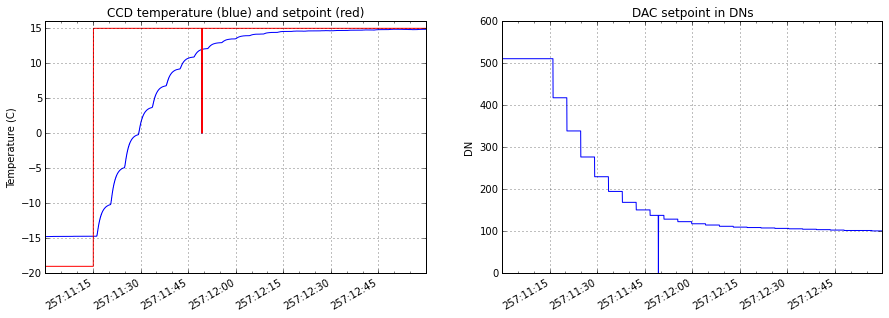

In [10]:
filename = 'ccd_temp_dac.dat'
if not os.path.exists(filename):
    dat = read_splat_dat()
    dat.write(filename, format='ascii.ecsv')
else:
    dat = Table.read(filename, format='ascii.ecsv', guess=False)

ok = ((dat['time'] > DateTime('2016:257:11:00:00').secs) &
      (dat['time'] < DateTime('2016:257:13:00:00').secs))
dat = dat[ok]

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plot_cxctime(dat['time'], dat['ccd_temp'], 'b')
plot_cxctime(dat['time'], dat['ccd_setpoint'], 'r')
plt.grid()
plt.ylabel('Temperature (C)')
plt.title('CCD temperature (blue) and setpoint (red)')
plt.ylim(-20, 16)

ax2 = plt.subplot(1, 2, 2, sharex=ax1)
plot_cxctime(dat['time'], dat['dac'], 'b')
plt.grid()
plt.ylabel('DN')
plt.title('DAC setpoint in DNs');

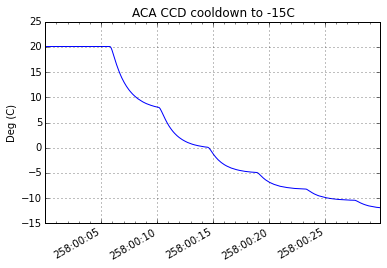

In [11]:
plt.figure()
ok = ccd_temp.times > DateTime('2016:258:00:00:00').secs
plot_cxctime(ccd_temp.times[ok], ccd_temp.vals[ok])
plt.grid()
plt.ylabel('Deg (C)')
plt.title('ACA CCD cooldown to -15C');

In [12]:
def fit_best_pixels(scale_quad=0.0, fit_scale_quad=False):
    fits = {}
    # Best pixels, picked by eye to represent the ones with the cleanest
    # fit, good signal and smallest flickering / noise
    best_pixels = ((7, 7, 7),  # slot, row, col 
                   (7, 6, 7),
                   (7, 3, 2),
                   (6, 0, 6),
                   (6, 5, 1),
                   (6, 0, 7))
    for slot_num, row, col in best_pixels:
        slot = slot6 if slot_num == 6 else slot7
        i_col = row * 8 + col

        t_ccd = slot['TEMPCCD'] - 273.15
        slot = slot[t_ccd > -13]
        esec = slot['IMGRAW'][:, i_col] * GAIN / slot['INTEG']
        fit_id = 's{}r{}c{}'.format(slot_num, row, col)
        print("slot {} pix idx {}".format(slot_num, i_col))
        fit, modpars  = fit_pix_values(t_ccd, esec, id=fit_id, scale_quad=scale_quad,
                                      fit_scale_quad=fit_scale_quad)

        fits[fit_id] = {'fit': fit,
                        'modpars': modpars,
                        'esec': esec,
                        't_ccd': t_ccd.copy(),
                        'dt': slot['TIME'] - DateTime(start).secs,
                        't0': DateTime(start).secs}
    return fits

In [13]:
def plot_fits(fits):
    fig, fitaxes = plt.subplots(len(fits), 3, figsize=(5 * 3, 5 * len(fits)))

    for i, fit_id in enumerate(fits):
        modplot = ui.get_model_plot(fit_id)

        timeax = fitaxes[i][0]
        fit = fits[fit_id]
        timeax.plot(fit['dt'] / 1000., fit['esec'], 'b')
        timeax.plot(fit['dt'] / 1000., modplot.y, 'r.')
        # timeax.set_xlim(1, 7)
        timeax.set_ylim(-200, 15000)
        timeax.grid()
        timeax.set_xlabel('time (ks from start)')
        timeax.set_title(fit_id)
        timeax.annotate("scale: {:.3f}".format(fit['modpars'].scale.val),
                        xy=(0.25, 0.75), xycoords="axes fraction",
                        ha='center', va='center')
        timeax.set_ylabel("e-/sec")

        fitax = fitaxes[i][1]
        ok = fit['esec'] > 10
        fitax.plot(fit['t_ccd'][ok], log10(fit['esec'][ok]), 'b.')
        print('Dataset {}'.format(i))
        print(fit['modpars'], '\n')
        ok = modplot.y > 10
        fitax.plot(modplot.x[ok], log10(modplot.y[ok]), 'r.')
        fitax.set_ylim(1.5, 4.5)
        fitax.grid()
        fitax.set_xlabel('t_ccd (C)')
        fitax.set_ylabel("e-/sec")

        timeax.set_ylabel("e-/sec")
        fitax = fitaxes[i][2]
        fitax.plot(fit['t_ccd'], fit['esec'], 'b.')
        fitax.plot(modplot.x, modplot.y, 'r.')
        fitax.set_ylim(-200, 15000)
        fitax.grid()
        fitax.set_xlabel('t_ccd (C)')
        fitax.set_ylabel("e-/sec")

    fig.subplots_adjust(left=.05, bottom=.1, right=.95, top=.95, wspace=.2, hspace=.2)


## Dark current scaling

This uses particular pixels that have been identified as having
relatively "clean" dark current changes during the event.  Primarily
this means that there was minimal flickering, but some pixels seem
to exhibit wobbly flickering in contrast to the discrete jumps that
are typical.

### Fit pure linear scaling

slot 7 pix idx 63
slot 7 pix idx 55
slot 7 pix idx 26
slot 6 pix idx 6
slot 6 pix idx 41
slot 6 pix idx 7
Dataset 0
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.635864          0.4            1           
   model.dark_t_ref thawed      270.243           50         5000           
   model.scale_quad frozen            0        -0.05         0.05            

Dataset 1
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.645076          0.4            1           
   model.dark_t_ref thawed      475.622           50         5000           
   model.scale_quad frozen            0        -0.05         0.05            

Dataset 2
usermodel.model
   Param        Type          Value          Min          Max     

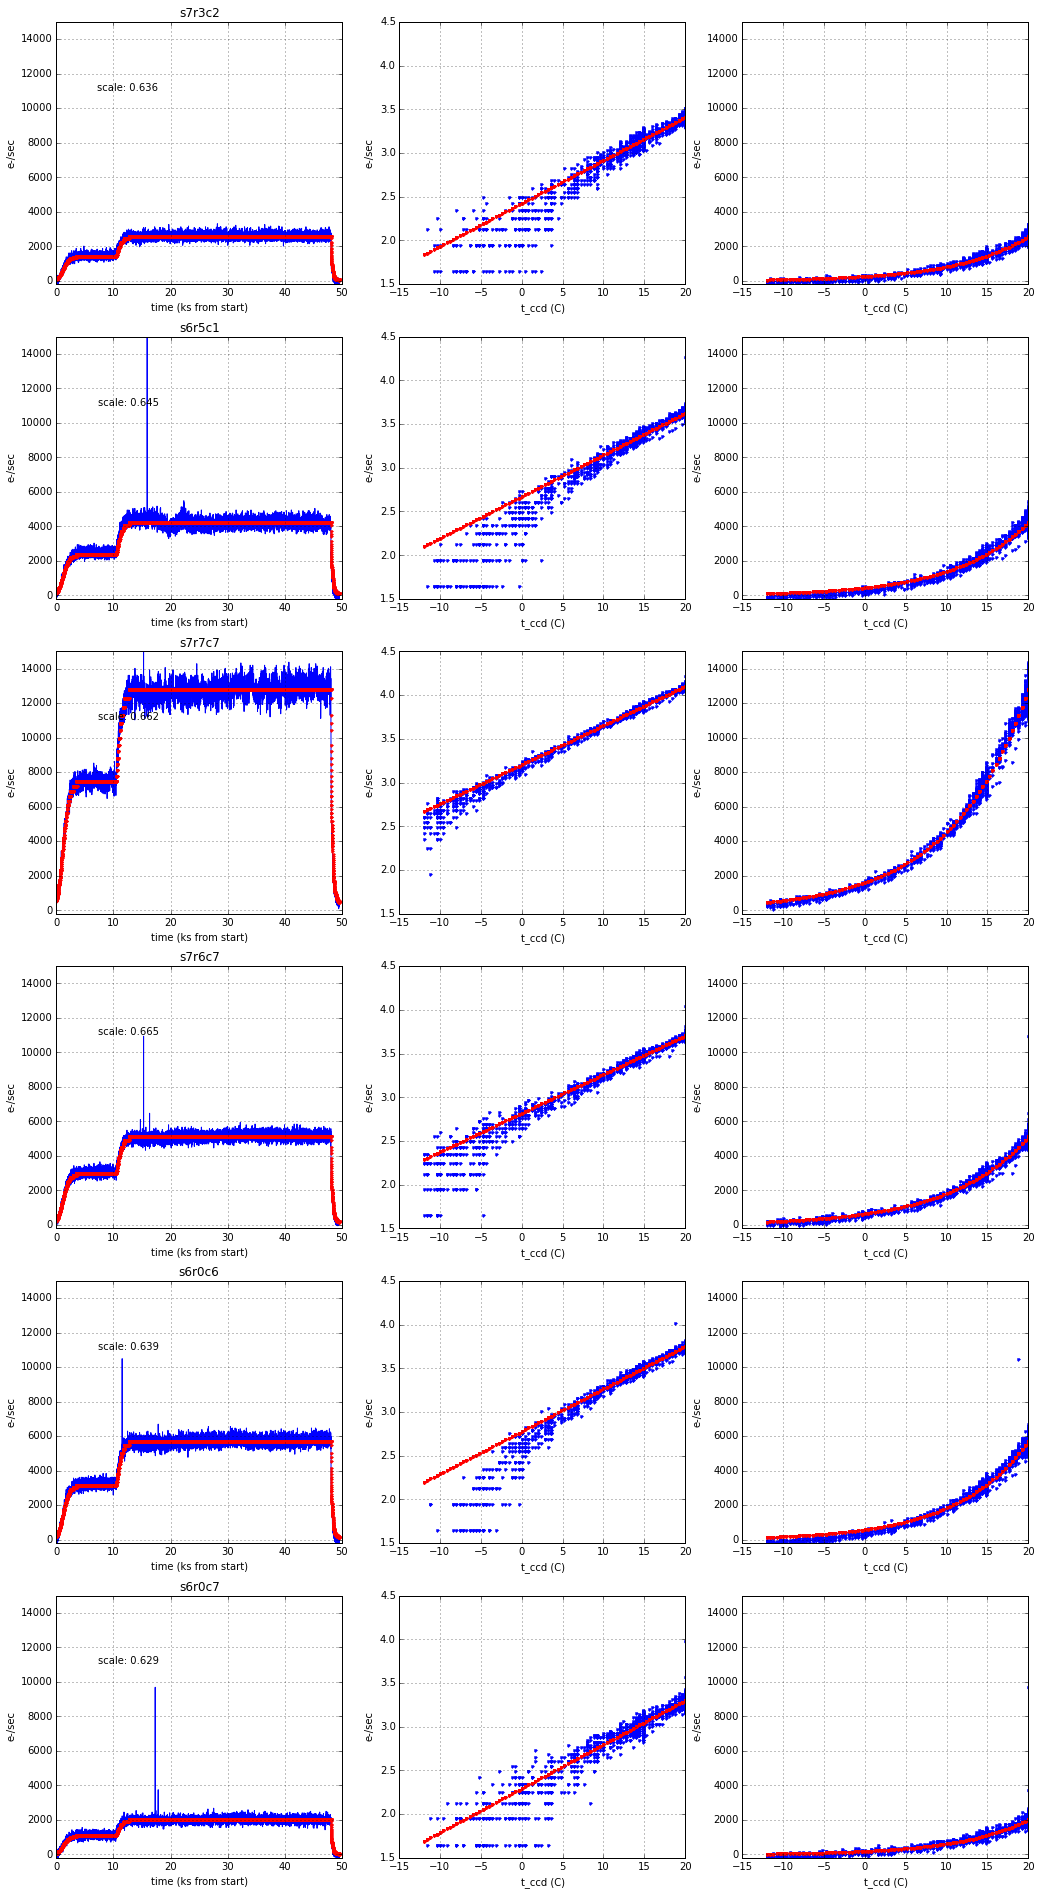

In [14]:
fits = fit_best_pixels(scale_quad=0, fit_scale_quad=False)
plot_fits(fits)

In [15]:
# best / only good fits fits are slot 7 63 and slot 7 18                                          
scales = [fit['modpars'].scale.val for fit in fits.values()]
scale = np.mean(scales)
print(['{:.4f}'.format(scale) for scale in scales])
print(scale)
print('Scaling per 4 C increase is {:.2f}'.format(1/scale))

['0.6359', '0.6451', '0.6619', '0.6649', '0.6388', '0.6288']
0.628772845488
Scaling per 4 C increase is 1.59


### Fit linear scaling with fixed quadratic term = -0.02

slot 7 pix idx 63
slot 7 pix idx 55
slot 7 pix idx 26
slot 6 pix idx 6
slot 6 pix idx 41
slot 6 pix idx 7
Dataset 0
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.539451          0.4            1           
   model.dark_t_ref thawed      195.652           50         5000           
   model.scale_quad frozen        -0.02        -0.05         0.05            

Dataset 1
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.547481          0.4            1           
   model.dark_t_ref thawed       345.01           50         5000           
   model.scale_quad frozen        -0.02        -0.05         0.05            

Dataset 2
usermodel.model
   Param        Type          Value          Min          Max     

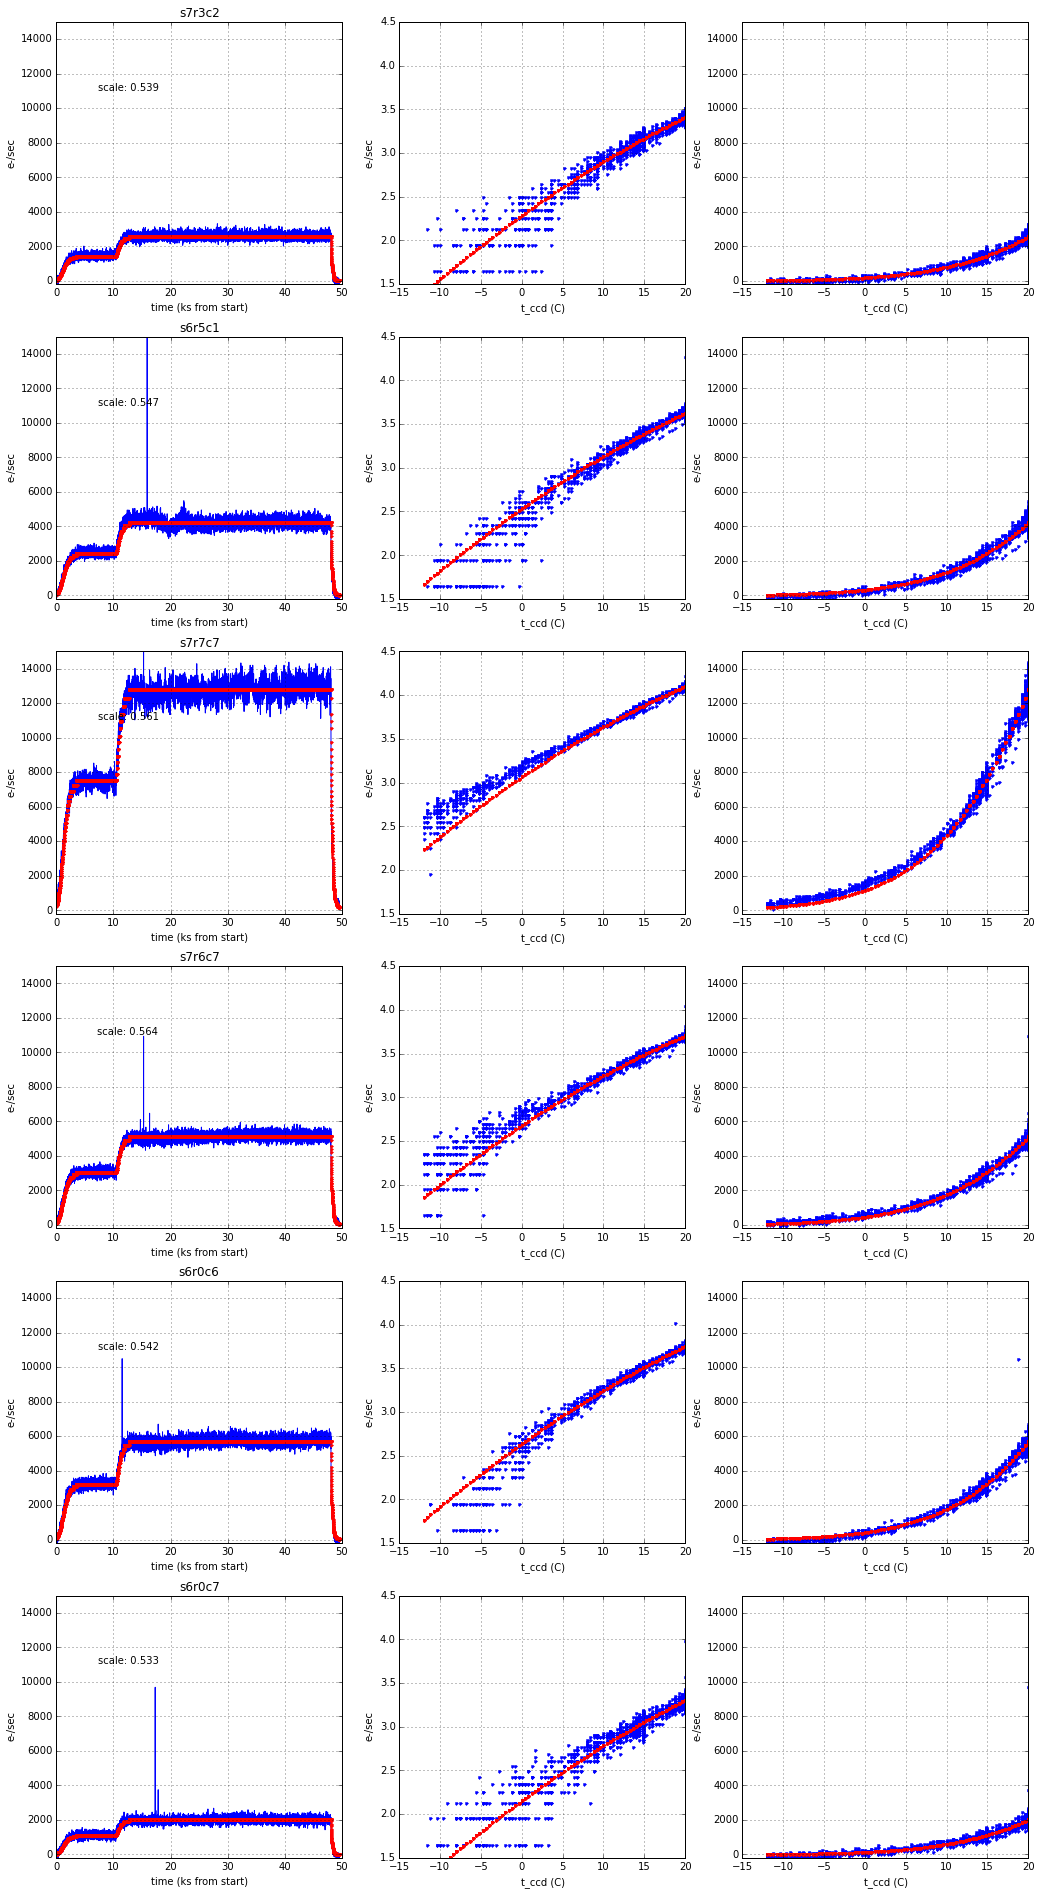

In [16]:
fits = fit_best_pixels(scale_quad=-0.02, fit_scale_quad=False)
plot_fits(fits)

## Fit the quadratic term

slot 7 pix idx 63
slot 7 pix idx 55
slot 7 pix idx 26
slot 6 pix idx 6
slot 6 pix idx 41
slot 6 pix idx 7
Dataset 0
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.483424          0.4            1           
   model.dark_t_ref thawed      156.687           50         5000           
   model.scale_quad thawed   -0.0330623        -0.05         0.05            

Dataset 1
usermodel.model
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   model.scale  thawed     0.460601          0.4            1           
   model.dark_t_ref thawed      242.904           50         5000           
   model.scale_quad thawed   -0.0405446        -0.05         0.05            

Dataset 2
usermodel.model
   Param        Type          Value          Min          Max     

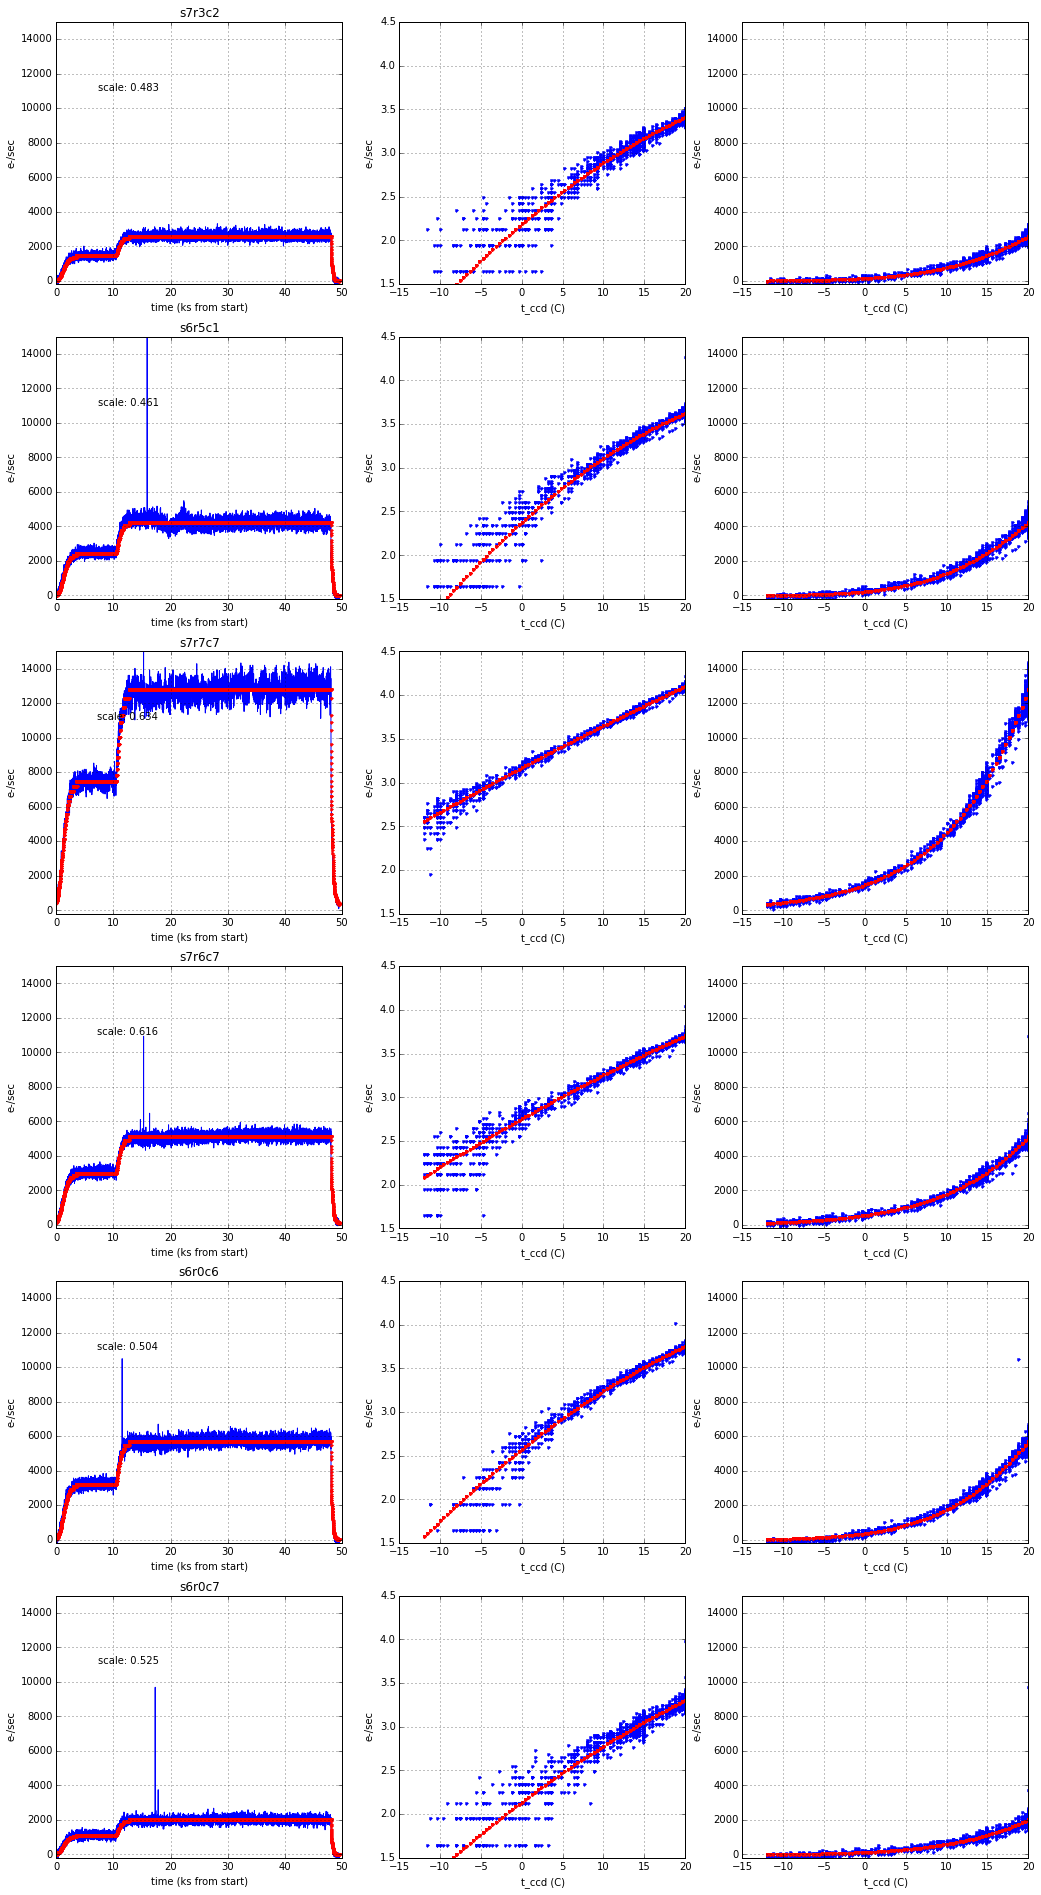

In [17]:
fits = fit_best_pixels(scale_quad=0, fit_scale_quad=True)
plot_fits(fits)

## Compare pixel slot=7, row=7, col=7 from pathfinder to 2016 anneal event

In [18]:
# Get pathfinder data
start = '2015:252:13:00:00.000'
stop = '2015:252:16:00:00.000'
p_ccd_temp = aca_hdr3.MSID('ccd_temp', start, stop)
p_slot7 = aca_l0.get_slot_data(start, stop, 7)

In [19]:
slot = p_slot7
i_col = 63

In [20]:
esec = slot['IMGRAW'][:, i_col] * GAIN / slot['INTEG']
t_ccd = slot['TEMPCCD'] - 273.15
ok = esec > 100

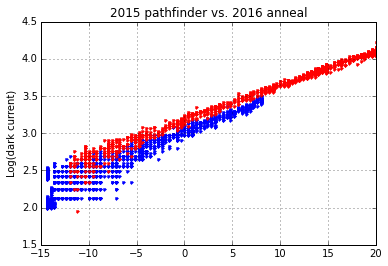

In [21]:
plt.plot(t_ccd[ok], np.log10(esec[ok]), '.')
plt.grid()

fit = fits['s7r7c7']
ok = fit['esec'] > 10
plt.plot(fit['t_ccd'][ok], np.log10(fit['esec'][ok]), 'r.')
plt.ylabel('Log(dark current)')
plt.title('2015 pathfinder vs. 2016 anneal')
